# Shoe Training via Same CNN Pipeline as Clothing

In [9]:
import numpy as np
from glob import glob

# import necessary keras modules
from keras.preprocessing import image 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

# custom functions
from layer_output import get_dense_layer, all_dense_data, path_to_tensor, paths_to_tensor
from loading import load_files       

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path, ignore_files='.DS_Store')
    shoe_files = np.array(data['filenames'])
    shoe_targets = np_utils.to_categorical(np.array(data['target']), 9)
    return shoe_files, shoe_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/shoes/train')
valid_files, valid_targets = load_dataset('../data/shoes/validate')
test_files, test_targets = load_dataset('../data/shoes/test')

# load list of clothing names
shoe_names = [item[20:-1] for item in sorted(glob("../data/shoes/train/*/"))]

# print info about the dataset
print(f'There are {len(shoe_names)} total shoe categories.')
print(f'There are {len(np.hstack([train_files, valid_files, test_files]))} total shoe images.\n')
print(f'There are {len(train_files)} training shoe images.')
print(f'There are {len(valid_files)} validation shoe images.')
print(f'There are {len(test_files)} test shoe images.')

There are 9 total shoe categories.
There are 24674 total shoe images.

There are 19975 training shoe images.
There are 2473 validation shoe images.
There are 2226 test shoe images.


In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
# rescale the images by dividing every pixel in every image by 255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2226/2226 [00:03<00:00, 712.69it/s]


## Build the CNN Architechture

In [10]:
model = Sequential()

# Define the architecture.
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=5, strides=2, padding='valid', activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=5, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.3))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())

model.add(Dense(units=300, activation='relu', name='vectors')) # extract vectors from here and cluster
model.add(Dropout(rate=0.3))
model.add(Dense(len(shoe_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          8256      
__________

In [11]:
# compile the model 
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [7]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)

In [12]:
epochs = 25

early_stop = early_stop = EarlyStopping(monitor='val_loss', patience=4)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_shoes.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer, early_stop], verbose=1)


Train on 19975 samples, validate on 2473 samples
Epoch 1/20
19975/19975 [==============================] - 168s 8ms/step - loss: 1.2573 - acc: 0.5324 - val_loss: 0.8824 - val_acc: 0.6915

Epoch 00001: val_loss improved from inf to 0.88237, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 2/20
19975/19975 [==============================] - 156s 8ms/step - loss: 0.8595 - acc: 0.6902 - val_loss: 0.6743 - val_acc: 0.7594

Epoch 00002: val_loss improved from 0.88237 to 0.67434, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 3/20
19975/19975 [==============================] - 151s 8ms/step - loss: 0.7659 - acc: 0.7270 - val_loss: 0.6284 - val_acc: 0.7727

Epoch 00003: val_loss improved from 0.67434 to 0.62837, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 4/20
19975/19975 [==============================] - 151s 8ms/step - loss: 0.6995 - acc: 0.7514 - val_loss: 0.6030 - val_acc: 0.7820

Epoch 00004: val_loss improved fr

## Graph of training/validation Accuracy and Loss

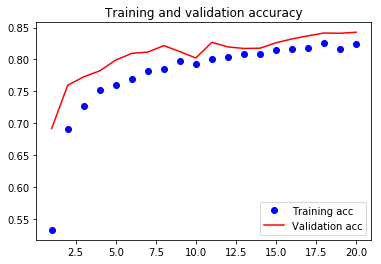

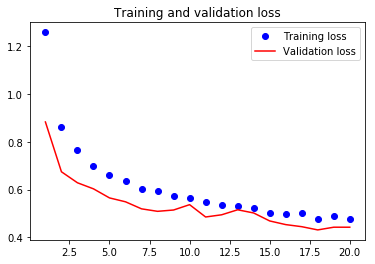

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', c='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
plt.title('Training and validation loss')
plt.legend();

In [14]:
# get index of predicted item for each image in test set
shoe_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(shoe_predictions)==np.argmax(test_targets, axis=1))/len(shoe_predictions)
print('Test accuracy: {}'.format(round(test_accuracy, 4)))

Test accuracy: 82.929


In [15]:
# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional
# -neural-networks-with-keras-260b36d60d0
model.save('saved_models/shoes_cnn.h5')
# load the model with best validation loss
model.load_weights('saved_models/weights.best.from_scratch_shoes.hdf5')


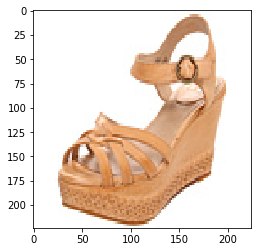

(1, 224, 224, 3)


In [17]:
img_path = '../data/shoes/test/sandals/7910998.332551.jpg'
img_tensor = path_to_tensor(img_path)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [21]:
# predicting images
images = np.vstack([img_tensor])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:", shoe_names[int(classes)])

Predicted class is: sandals


## Get a matrix of all images Dense layer stacked

In [34]:
# takes too long to run this need AWS
all_dense, dense_df = all_dense_data(model, train_files)
pickle.dump(dense_df, open("saved_models/dense_shoe_df.pickle", "wb" ))
print(all_dense.shape)
print(dense_df.shape)
dense_df.head()


### K-Means cluster graphed

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

X = all_train_dense
targets = np.array([np.where(target == 1)[0][0] for target in train_targets])

pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
kmeans = KMeans(n_clusters=14, random_state=11)
kmeans.fit(X)
pl.figure('K-means with 10 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, cmap='tab10');

In [35]:
import torch
torch.cuda.is_available()

ModuleNotFoundError: No module named 'torch'